# Assessing Capture Experiments <br>*with R-package TEQC - Target Enrichment Quality Control*

### ABOUT

TEQC is a BioConductor R library that can help in assessing whether a target/exome capture experiment has been successful. It can be used to answer whether most of the sequenced reads actually fall on the target, the targeted bases reach sufficient coverage, etc, and generate respective figures.

TEQC provides multiple functionalities and quality measures of:

 - specificity and sensitivity of the capture, 
 - enrichment,
 - per-target read coverage, 
 - coverage uniformity and reproducibility, 
 - and read duplicate analysis.
 
The analyses can be based on either single reads or read pairs in case of paired-end sequence data. Results are given as values, tables, and diagnostic plots. Below an example analysis. Use this guide along with the [TEQC documentation](https://bioconductor.org/packages/release/bioc/html/TEQC.html).
It seems that TEQC currently only handles one sample at a time, i.e., the bamfile is not parsed for specific samples.

**Authors of the TEQC package:**

Hummel M, Bonnin S, Lowy E, Roma G (2020). TEQC: Quality control for target capture experiments. R package version 4.12.0.

Hummel M, Bonnin S, Lowy E, Roma G. TEQC: an R package for quality control in target capture experiments. Bioinformatics. 2011 May 1;27(9):1316-7. doi: 10.1093/bioinformatics/btr122. Epub 2011 Mar 12. PMID: 21398674.


> _Authors of this Jupyter notebook: Anibal Morales, Norman Warthmann (FAO/IAEA Joint Center)_ <br>
> _**We ran TEQC using R version 4.0.3 through Jupyter Notebook on Linux Ubuntu 16.04 Xenial**._

### INSTALLING CONDA, R, AND JUPYTER NOTEBOOK

We recommend installing all necessary packages and dependencies through conda/mamba into a dedicated conda virtual environment. For installing conda follow instruction on the [Miniconda Webpage](https://docs.conda.io/en/latest/miniconda.html). Miniconda3 might install python 2.7. In order to force Python3, explicitly install the preferred Python version and update conda subsequently to resolve dependencies.

Code for Linux terminal is prefixed with "**$**" <br>
Code for the R terminal is prefixed with "**>**"


```
$ conda create --name R-TEQC python=3.x
$ conda activate R-TEQC
$ mamba install samtools=1.11
$ mamba install R
$ mamba install jupyter
$ mamba install r-irkernel

```

Start jupyter notebook

```
$ jupyter notebook
```

Note:

Our script ran on **R version 4.0.3**. Run the analysis either through Jupyter Notebook or from the R command prompt (terminal). **Note: When installing through conda, then don't install Rstudio. Currently, installing Rstudio will downgrade R to version 3.6**, which we didn't test. To run R in Jupyter Notebook you need to install/add the R kernel, if you are having trouble with the install of r-irkernel through mamba, you may install it trhoug R as below:

```
$ R
> install.packages('IRkernel')
> IRkernel::installspec()
> quit()
```



### LIBRARY INSTALLATION

Suppress all warning messages.

In [28]:
#options(warn=-1)

For installing from Bioconductor, check if BiocManager is installed. If not: install. (Define version if needed)

In [5]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.13", ask=FALSE)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'BiocVersion'

Installing package(s) 'Biobase', 'BiocGenerics', 'BiocParallel', 'BiocVersion',
  'Biostrings', 'bitops', 'fansi', 'formatR', 'GenomeInfoDb',
  'GenomeInfoDbData', 'GenomicRanges', 'IRanges', 'RCurl', 'Rhtslib',
  'Rsamtools', 'S4Vectors', 'survival', 'TEQC', 'XVector', 'zlibbioc'



Install TEQC with _**BiocManager**_ and load it.

In [6]:
BiocManager::install("Rsamtools")
BiocManager::install(c("TEQC"))


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'Rsamtools'”
'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'TEQC'”


In [7]:
library(TEQC)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: IRanges

Loading required package: S4Vectors

Loading required package: stats4


Attachin

# Load Mapped Reads (Bam file) and Capture Targets (bed file)

The minimum input is 2 files:

1. One **bed** file containing the genomic positions (chromosome, start, end) of the targeted regions, one genomic range per line, and  
2. One **bam** (or **bed**) file containing the genomic positions(chromsome, start, end) of sequenced reads aligned to a reference genome, one genomic range per line.

**BED File Path - Targets**

> _**Our orignal **bed** file threw errors. Suppplying only the first 3 columns of the file to the `get.targets()` function worked fine.**._

In [8]:
#cut -f 1,2,3 /home/norman/data/coffee/Design_Coffee_exome_capture_291019/from_ArborBioSci/Arbor_CoffexomeV1-PredictedPotentialCovg-Exons.table.f1-f4f10f6.bed > /home/norman/data/coffee/Design_Coffee_exome_capture_291019/from_ArborBioSci/test.bed
targetsfile <- file.path("/home/norman/data/coffee/Design_Coffee_exome_capture_291019/from_ArborBioSci/test.bed")

**BAM File Paths -Reads** 

In [9]:
## Input files for coffee76 (76 samples at PBGL)
# setwd("/data/norman/coffee/Analysis_2020_coffee76/TEQC-Analysis")
# readsfile <- file.path("/home/norman/data/coffee/Analysis_2020_coffee76/dna-proto-workflow/output/abra/bwa~GCF_003713225.1_Cara_1.0~all_samples.bam")

## Input files for coffee-pilot (12 samples at Arbor)
setwd('/home/norman/data/coffee/Analysis_2020_pilot/TEQC-Analysis')
readsfile <- file.path("/home/norman/data/coffee/Analysis_2020_pilot/dna-proto-workflow/output/abra/bwa~GCF_003713225.1_Cara_1.0~all_samples.bam")


### Read data

**`get.targets(targetsfile, chrcol, startcol, endcol, skip)`**:
- output of class GRanges from the *GenomicRanges* package.
- overlapping or adjacent targets are merged, such that the returned target regions are non-overlapping.
- _**targetsfile**_: 
    - **bed** file 
    - does not need to have a fixed format, rather 3 columns containing (chromosome, start, end), see problems we had above
- _**chrcol**_:
    - chromosome column as string
- _**startcol**_:
    - start position of each target
- _**endcol**_:
    - end position of each target
- _**skip**_:
    - set to 0 (FALSE) to avoid shifting by 1, since TEQC uses 1-based coordinates

**`get.reads(readsfile, filetype)`**:
- similar to **`get.targets()`**, however overlapping or identical reads are not merged.
- multiple matches per read on the genome are not supported.
- whenever **bam** files are available, use the bam file (specify `filetype = "bam"`). Then `get.reads()` uses functionality of `scanBam`, and multiple matches are supposedly skipped.
- reads can also be supplied as bed files. Consult the TEQC documentation for details.


In [10]:
targets <- get.targets(targetsfile, chrcol = 1, startcol = 2, endcol = 3, skip = 0)
reads <- get.reads(readsfile, filetype = "bam")

[1] "read 509082 target regions in total, which are collapsed to 275612 non-overlapping target regions"
[1] "read 248592199 sequenced reads"


### Fraction Calculation - how much of the reference genome is covered by the targets?

**`fraction.target(targets, Offset, genome = c(NA, "hg38", "hg19", "hg18"), genomesize)`**:
- calculate the fraction of the reference genome that is covered by targets (We calculated the genome size of coffee by summing up the chromosome lengths of the 22 real chromosomes: 82,4528,171 bp).
- returns the fraction of nucleotides within the genome that were targeted.
- can later be used with the **`fraction.reads.target()`** output to calculate the **enrichment** of the target capture experiment (see further below): `enrichment = fraction of on-target reads / fraction of target within genome`
- ***targets***:
    - `RangedData` table containing positions of target regions, i.e., output from **`get.targets()`**
- ***Offset***:
    - integer; adds `Offset` bases to both sides of targeted regions and potentially collapses resulting overlapping target regions
- ***genome***:
    - the genome (name) where targets were designed against and reads aligned to. For genomes unknown to the software (ie, non-human) put `NA` and specify `genomesize`.
- ***genomesize***:
    - integer: specify the total genome size manually. 
    - if `genomesize` is given, option `genome` will be ignored.

In [11]:
ft<-fraction.target(targets, Offset = 0, genome = NA, 824528171)
ft

[1] 0.1146338

###  Merge reads to read pairs <br><br> <span style="color:red">(currently not working for our bam files produced by bwa mem)</span>

**`reads2pairs(reads, max.distance)`**:
- combines the two reads of a read pair (in case of paired-end data) to a new 'range' starting at the first read's start position and ending at the second read's end position.
- ***reads***:
    - table containing positions of sequenced reads, i.e. output of **`get.reads()`**
- ***max.distance***:
    - integer value defining the maximum allowed distance between two reads of a pair (from start position of first read to end position of second read).
- currently outputs an error, which may be due to **`scanBam`** and the **`isSecondaryAlignment=False`** option when **`get.reads()`** is used:    

```
Error in reads2pairs(reads): read pair IDs do not seem to be unique
Traceback:
1. reads2pairs(reads)
2. stop("read pair IDs do not seem to be unique")
```



In [12]:
readpairs <- reads2pairs(reads)

ERROR: Error in reads2pairs(reads): read pair IDs do not seem to be unique


# SPECIFICITY AND ENRICHMENT

### TARGET CAPTURE SPECIFICITY

**`fraction.reads.target(reads, targets, Offset, mappingReads)`**:
- calculating fraction of reads that align/overlap the target regions (offset is added to either sides of target intervals)
- can be used with the **`fraction.target()`** output to calculate the **enrichment** of the target capture experiment:
    - `enrichment = fraction of on-target reads / fraction of target within genome`
- ***reads***:
    - table containing positions of sequenced reads, i.e. output of **`get.reads()`**
- ***targets***:
    - table containing positions of target regions, i.e. output of **`get.targets()`**
- ***Offset***:
    - integer; add an offset on both sides to targeted regions and potentially collape resulting overlapping target regions
- ***mappingReads***:
    - set to `TRUE` or `FALSE`
    - if `TRUE`, reduced `RangedData` table with only those reads mapping to target regions is returned.
    - if `FALSE` (default), just the fraction of `reads / read pairs mapping to targets` is returned

In [13]:
fr <- fraction.reads.target(reads,targets)
fr_offset100 <- fraction.reads.target(reads,targets, Offset=100)
fr_offset200 <- fraction.reads.target(reads,targets, Offset=200)
fr
fr_offset100
fr_offset200

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': NW_020848442.1, NW_020848443.1, NW_020848444.1, NW_020848445.1, NW_020848447.1, NW_020848448.1, NW_020848450.1, NW_020848453.1, NW_020848455.1, NW_020848456.1, NW_020848457.1, NW_020848458.1, NW_020848459.1, NW_020848460.1, NW_020848462.1, NW_020848464.1, NW_020848465.1, NW_020848467.1, NW_020848468.1, NW_020848469.1, NW_020848470.1, NW_020848472.1, NW_020848473.1, NW_020848474.1, NW_020848475.1, NW_020848477.1, NW_020848478.1, NW_020848479.1, NW_020848480.1, NW_020848481.1, NW_020848482.1, NW_020848483.1, NW_020848484.1, NW_020848485.1, NW_020848486.1, NW_020848487.1, NW_020848489.1, NW_020848490.1, NW_020848491.1, NW_020848492.1, NW_020848493.1, NW_020848494.1, NW_020848495.1, NW_020848496.1, NW_020848497.1, NW_020848498.1, NW_020848499.1, NW_020848500.1, NW_020848501.1, NW_020848503.1, NW_020848504.1, NW_020848505.1, NW_020848506.1, NW_020848507.1, NW_02084850

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': NW_020848442.1, NW_020848443.1, NW_020848444.1, NW_020848445.1, NW_020848447.1, NW_020848448.1, NW_020848450.1, NW_020848453.1, NW_020848455.1, NW_020848456.1, NW_020848457.1, NW_020848458.1, NW_020848459.1, NW_020848460.1, NW_020848462.1, NW_020848464.1, NW_020848465.1, NW_020848467.1, NW_020848468.1, NW_020848469.1, NW_020848470.1, NW_020848472.1, NW_020848473.1, NW_020848474.1, NW_020848475.1, NW_020848477.1, NW_020848478.1, NW_020848479.1, NW_020848480.1, NW_020848481.1, NW_020848482.1, NW_020848483.1, NW_020848484.1, NW_020848485.1, NW_020848486.1, NW_020848487.1, NW_020848489.1, NW_020848490.1, NW_020848491.1, NW_020848492.1, NW_020848493.1, NW_020848494.1, NW_020848495.1, NW_020848496.1, NW_020848497.1, NW_020848498.1, NW_020848499.1, NW_020848500.1, NW_020848501.1, NW_020848503.1, NW_020848504.1, NW_020848505.1, NW_020848506.1, NW_020848507.1, NW_02084850

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': NW_020848442.1, NW_020848443.1, NW_020848444.1, NW_020848445.1, NW_020848447.1, NW_020848448.1, NW_020848450.1, NW_020848453.1, NW_020848455.1, NW_020848456.1, NW_020848457.1, NW_020848458.1, NW_020848459.1, NW_020848460.1, NW_020848462.1, NW_020848464.1, NW_020848465.1, NW_020848467.1, NW_020848468.1, NW_020848469.1, NW_020848470.1, NW_020848472.1, NW_020848473.1, NW_020848474.1, NW_020848475.1, NW_020848477.1, NW_020848478.1, NW_020848479.1, NW_020848480.1, NW_020848481.1, NW_020848482.1, NW_020848483.1, NW_020848484.1, NW_020848485.1, NW_020848486.1, NW_020848487.1, NW_020848489.1, NW_020848490.1, NW_020848491.1, NW_020848492.1, NW_020848493.1, NW_020848494.1, NW_020848495.1, NW_020848496.1, NW_020848497.1, NW_020848498.1, NW_020848499.1, NW_020848500.1, NW_020848501.1, NW_020848503.1, NW_020848504.1, NW_020848505.1, NW_020848506.1, NW_020848507.1, NW_02084850

[1] 0.8252417

[1] 0.8956208

[1] 0.9192173

**fr** = 0.825241740590581    

**fr_offset100** = 0.895620803450876    

**fr_offset200** = 0.919217324273317    

### READS PER CHROMOSOME BARPLOT

**`chrom.barplot(reads, targets, plotchroms)`**:
- barplot of numbers (or fractions) of reads (and targets) falling on each chromosome.
- ***reads***:
    - table containing read positions, i.e. output from **`get.reads()`**.
- ***targets***:
    - table containing positions of target regions, i.e. output from **`get.targets()`**. 
    - the chromosome information should match the one of **`reads`**.
- ***plotchroms***:
    - character vector specifying the chromosomes that shall be included in the plot (and their desired order).

The functions **`pdf("name-of-pdf-file.pdf")`** and **`dev.off()`** are used to open a pdf file, write the image into it, and close the pdf file.

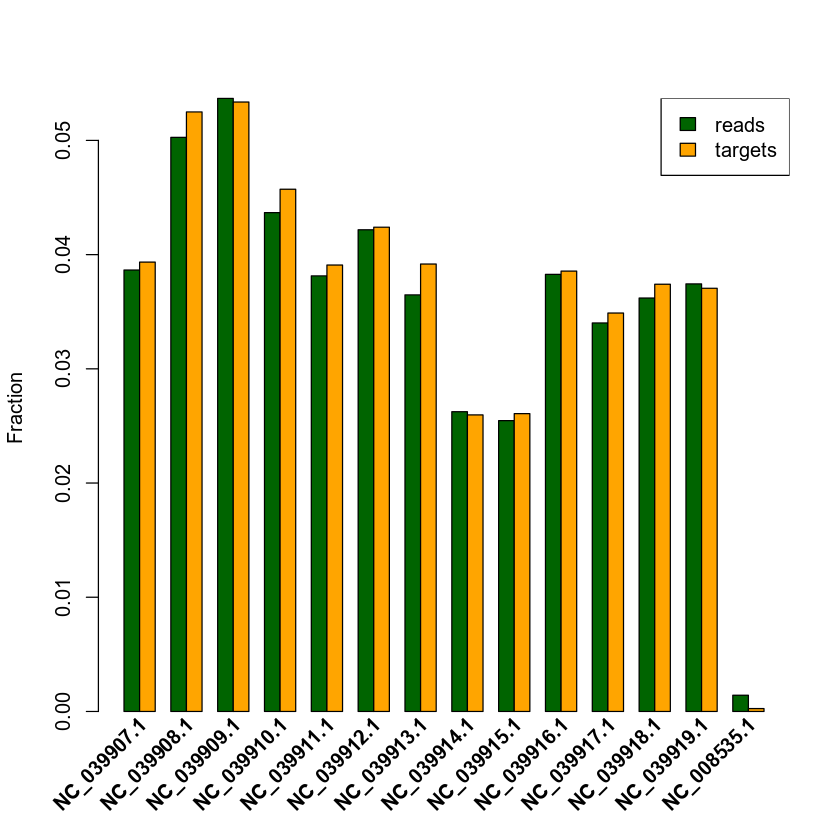

In [14]:
# pdf("On-target-Chrom-barplot-rplot.pdf")
chrom.barplot(reads, targets,c("NC_039907.1","NC_039908.1","NC_039909.1","NC_039910.1","NC_039911.1","NC_039912.1","NC_039913.1","NC_039914.1","NC_039915.1","NC_039916.1","NC_039917.1","NC_039918.1","NC_039919.1","NC_008535.1"))
# dev.off()

### ENRICHMENT CALCULATION


$enrichment = \displaystyle \frac{fraction\ of\ on-target\ reads\ (fr)}{fraction\ of\ target\ within\ genome\ (ft)}$


In [15]:
fr/ft
fr_offset100/ft
fr_offset200/ft

[1] 7.198941

[1] 7.812888

[1] 8.018731

# COVERAGE

**`coverage.target(reads, targets, Offset, perTarget, perBase)`**:
- calculates read coverage for each base that is sequenced and/or located in the target region.
- ***reads***:
    - table containing positions of sequenced reads, i.e. output from **`get.reads()`**.
- ***targets***:
    - table containing positions of target regions, i.e. output from **`get.targets()`**.
- ***Offset***:
    - integer; add `Offset` bases on both sides to targeted regions and potentially collapse resulting overlapping target regions.
- ***perTarget***:
    - if TRUE, coverage average and standard deviation per target are calculated and returned.
- ***perBase***:
    - if TRUE, the per-base coverages:
        1. only for targeted bases, and 
        2. for all sequenced and/or targeted bases, are returned.

**`readsPerTarget(reads, targets, Offset)`**:
- counts the numbers of reads overlapping each target region.
- ***reads***:
    - table containing positions of sequenced reads, i.e. output from **`get.reads()`**.
- ***targets***:
    - table containing positions of target regions, i.e. output from **`get.targets()`**.
- ***Offset***:
    - integer; add `Offset` bases on both sides to targeted regions and potentially collapse resulting overlapping target regions.

In [16]:
Coverage <- coverage.target(reads, targets, perTarget=T, perBase=T)
#Coverage <- coverage.target(reads, targets, perTarget=T)

targets2 <- Coverage$targetCoverages
targets2 <- readsPerTarget(reads, targets2)
#targets2

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': NW_020848580.1, NW_020849658.1, NW_020850188.1, NW_020850423.1
  - in 'y': NW_020848442.1, NW_020848443.1, NW_020848444.1, NW_020848445.1, NW_020848447.1, NW_020848448.1, NW_020848450.1, NW_020848453.1, NW_020848455.1, NW_020848456.1, NW_020848457.1, NW_020848458.1, NW_020848459.1, NW_020848460.1, NW_020848462.1, NW_020848464.1, NW_020848465.1, NW_020848467.1, NW_020848468.1, NW_020848469.1, NW_020848470.1, NW_020848472.1, NW_020848473.1, NW_020848474.1, NW_020848475.1, NW_020848477.1, NW_020848478.1, NW_020848479.1, NW_020848480.1, NW_020848481.1, NW_020848482.1, NW_020848483.1, NW_020848484.1, NW_020848485.1, NW_020848486.1, NW_020848487.1, NW_020848489.1, NW_020848490.1, NW_020848491.1, NW_020848492.1, NW_020848493.1, NW_020848494.1, NW_020848495.1, NW_020848496.1, NW_020848497.1, NW_020848498.1, NW_020848499.1, NW_020848500.1, NW_020848501.1, NW_020848503.1, 

Write coverage results ot a file. (Create dataframe of `targets2` and write it to file `target_coverage.txt`). Ensure the desired working directory is set or specify full path. It will return a table listing all targets and determined coverage with the follwing columns: <br>

    seqnames	start	end	width	strand	avgCoverage	coverageSD	nReads

In [17]:
#setwd()
write.table(as.data.frame(targets2), file="target_coverage_28-8-2021.txt",sep="\t", row.names=F, quote=F)

### TARGET CAPTURE SENSITIVITY

**`covered.k(coverageTarget, k=c(1, 2, 3, 5, 10, 20, ..., N)`**:
- calculates fraction of target bases covered based on the **`coverageTarget`** output of **`coverage.target()`** by at least **k** reads.
- ***coverageTarget***:
    - list containing vectors of per-target-base coverages for each chromosome, i.e. **`coverageTarget`** output from **`coverage.target()`**.
- ***k***:
    - specifies the values for which to calculate the fraction of bases achieving the respective coverage (k).

In [18]:
covered.k(Coverage$coverageTarget, k=c(1, 5, 10, 20, 40))

1         5        10        20        40 
0.9562543 0.9238584 0.9096977 0.8846434 0.8317090

**`coverage.hist(coverageTarget, covthreshold)`**:
- histogram of read coverages for bases within the target. 
- additionally, a line and the right axis indicate the cumulative fraction of target bases with coverage of at least x. 
- if option **`covthreshold`** is specified, red dashed lines highlight the cumulative fraction of target bases with at least the specified coverage.
- ***coverageTarget***:
    - list containing vectors of per-target-base coverages for each chromosome, i.e. **`coverageTarget`** output from **`coverage.target()`**.
- ***covthreshold***:
    - indicates with dashed vertical and horizontal lines, which fraction of bases has a coverage of at least **`covthreshold`**; if missing, no dashed lines are drawn.

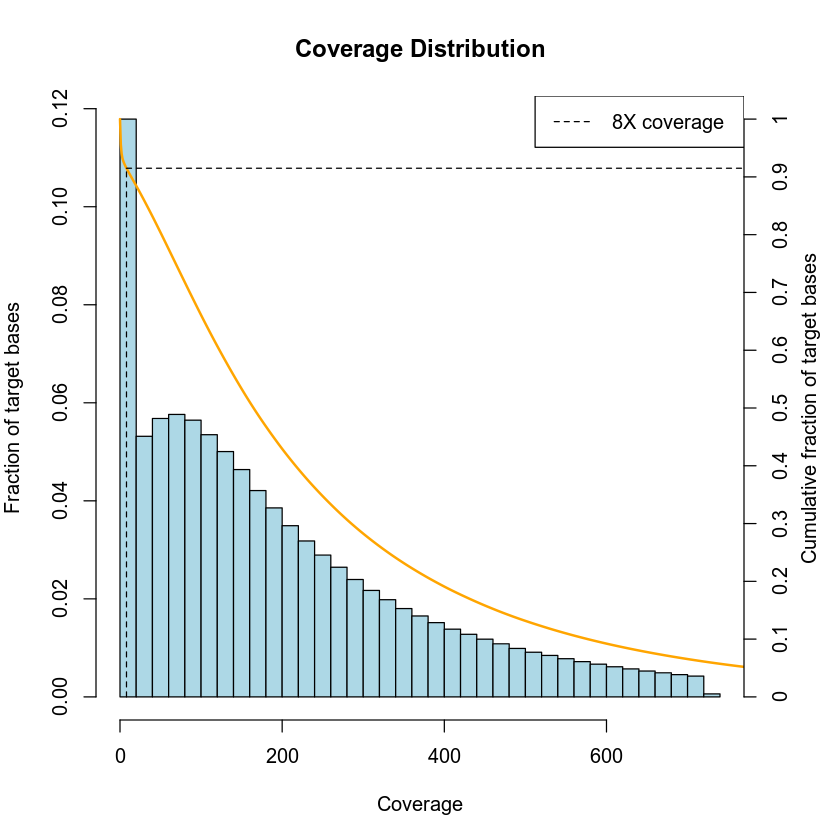

In [19]:
# pdf("Coverage-distribution-rplot.pdf")
coverage.hist(Coverage$coverageTarget, covthreshold=8)
# dev.off()

**`coverage.uniformity(coveragelist)`**:
- visualization of target coverage uniformity. 
- a line shows the cumulative fraction of targeted bases that reach at least a certain normalized coverage.
- ***coveragelist***:
    - output of function **`coverage.target()`**, where option `perBase` had to be set to `TRUE`, i.e. a list with elements `coverageTarget` and `avgTargetCoverage`.

In [ ]:
# pdf("Coverage-uniformity-rplot.pdf")
coverage.uniformity(Coverage)
# dev.off()

**`coverage.targetlength.plot()`** calculates the number of reads or average coverage versus tanget length.  
  
**`coverage.targetlength.plot(targets, plotcolumn, pch, cex)`**:
- plots either numbers of on-target reads or average per-target coverage (or potentially other per-target values) against respective target lengths. 
- a smoothing spline is added to the scatter plot.
- ***targets***:
    -  table containing positions of target regions and further 'values' columns that should be plotted, i.e. output from **`coverage.target()`** or **`readsPerTarget`**.
- ***plotlocumn***:
    - name or index of column to plot (of the 'values' DataFrame within **`targets`**.
- ***pch***:
    - plotting character.
    - **`16`** = filled circle
- ***cex***:
    - size of plotting character.

In [ ]:
# pdf("Coverage-Target-length-rplot.pdf")
par(mfrow=c(1,2))
coverage.targetlength.plot(targets2, plotcolumn="nReads", pch=16,cex=1.5)
coverage.targetlength.plot(targets2, plotcolumn="avgCoverage", pch=16,cex=1.5)
# dev.off()

### Coverage Plots for Genes-of-Interest

Examples: Caffeine pathway genes:
```
Chromosome	Start	End	Name
NC_039914.1	7473077	7475443	LOC113708510-9c-CaXMT1
NC_039915.1	6714444	6716737	LOC113710464-9e-CaXMT2
NC_039914.1	7430405	7432582	LOC113707907-9c-CaMXMT1
NC_039915.1	6674915	6677084	LOC113710465-9e-CaMXMT2
NC_039898.1	1392954	1395287	LOC113688632-1c-CaDXMT2
NC_039899.1	893020	895356	LOC113697595-1e-CaDXMT1a
NC_039899.1	884021	886305	LOC113697586-1e-CaDXMT1b
```

**`coverage.plot(coverageAll, targets, Offset, chr, Start, End, main)`**:
- line plot of per-base coverages along a genomic region. 
- position of target regions can be shown.
- ***coverageAll***:
    - list containing vectors of per-base coverages for each chromosome, i.e. **`coverageAll`** output from **`coverage.target()`**.
- ***targets***:
    - optional; table containing positions of target regions, i.e. output from **`get.targets()`**; if missing no genomic regions are highlighted.
- ***Offset***:
    - integer; highlight `Offset` bases on both sides of each targeted region; defaults to 0.
- ***chr***:
    - on which chromosome the region to plot is located (string, e.g. "chr1").
- ***Start***:
    - genomic position where to start the plot.
- ***End***:
    - genomic position where to end the plot.
- ***main***:
    - image title.

In [ ]:
# pdf("Coverage-plots-caffeine-genes.pdf")
coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039914.1",Start=7473077, End=7475443, main="LOC113708510-9c-CaXMT1")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039915.1",Start=6714444, End=6716737, main="LOC113710464-9e-CaXMT2")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039914.1",Start=7430405, End=7432582, main="LOC113707907-9c-CaMXMT1")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039915.1",Start=6674915, End=6677084, main="LOC113710465-9e-CaMXMT2")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039898.1",Start=1392954, End=1395287, main="LOC113688632-1c-CaDXMT2")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039899.1",Start=893020, End=895356, main="LOC113697595-1e-CaDXMT1a")
#coverage.plot(Coverage$coverageAll, targets, Offset=100, chr="NC_039899.1",Start=884021, End=886305, main="LOC113697586-1e-CaDXMT1b")
# dev.off()

# READ DUPLICATES

**`duplicates.barplot(reads, targets, xlim)`**:
- barplot showing fractions of reads / read pairs which are unique and for which there are two, three, ... copies.
- separate bars are made for on- and off-target reads / read pairs.
- ***reads***:
    - table containing positions of sequenced reads, i.e. output from **`get.reads()`**. 
    - alternatively, for paired-end data, it can be the output of **`reads2pairs`** when multiplicities of read pairs instead of fraction of single reads shall be visualized.
- ***targets***:
    - table containing positions of target regions, i.e. output from **`get.targets()`**.
- ***xlim***:
    - x-axis coordinate ranges.

In [1]:
# pdf("Duplicates-barplot.pdf")
duplicates.barplot(reads, targets, xlim=c(0,12))
# dev.off()

ERROR: Error in duplicates.barplot(reads, targets, xlim = c(0, 12)): could not find function "duplicates.barplot"
